In [1]:
%cd ..

/home/isaiah/code/NestedGraphs


In [2]:
import glob 
import pickle
import torch 

from utils.graph_utils import propagate_labels

FEATS = 'feature_extraction/data/features/'
GRAPHS = 'inputs/Sept23/mal/'

In [3]:
embs = []
labels = []
valid = []
missing=[]

offset = 0
for gf in glob.glob(GRAPHS+'*.pkl'):
    with open(gf, 'rb') as f:
        g = pickle.load(f)

    procs = (g.x[:,0] == 1).nonzero()
    y = propagate_labels(g, 23)[procs].clamp(0,1)

    uuids = []
    for p in procs:
        uuids.append(g.get(p)['uuid'])

    # This will be updated so the dict doesn't have to be made
    # every time
    mapping,feats = torch.load(FEATS+'%d.pkl' % g.gid)
    mapping = {m:i for i,m in enumerate(mapping)}
    
    tot_missing = [0,0]
    for i,uuid in enumerate(uuids):
        if fid := mapping.get(uuid):
            embs.append(feats[fid])
            valid.append(i+offset)
        else:
            missing.append((uuid,y[i]))
            if y[i]:
                tot_missing[0]+=1
            else:
                tot_missing[1]+=1
            
            embs.append(torch.zeros(feats.size(1), device=feats.device))
    print("Total missing: %d/%d mal, %d benign" % (tot_missing[0],y.sum().item(),tot_missing[1]))
    offset += procs.size(0)

    labels.append(y)

embs = torch.stack(embs)
labels = torch.cat(labels, dim=0)
valid = torch.tensor(valid)

print(embs.size(),labels.size())
print(embs)

Total missing: 0/0 mal, 820 benign
Total missing: 1/3 mal, 1085 benign
Total missing: 1/3 mal, 818 benign
Total missing: 0/1 mal, 1387 benign
Total missing: 1/3 mal, 767 benign
Total missing: 1/3 mal, 1090 benign
Total missing: 0/3 mal, 1309 benign
Total missing: 1/3 mal, 1118 benign
Total missing: 1/3 mal, 1166 benign
Total missing: 0/3 mal, 1131 benign
Total missing: 1/3 mal, 1292 benign
Total missing: 0/4 mal, 1149 benign
Total missing: 0/3 mal, 1301 benign
Total missing: 0/3 mal, 1130 benign
Total missing: 1/3 mal, 1059 benign
Total missing: 12/269 mal, 1524 benign
Total missing: 12/255 mal, 1401 benign
torch.Size([86389, 128]) torch.Size([86389, 1])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.1379, -0.2820, -0.1315,  ..., -0.1061, -0.3675,  0.1687],
        [ 0.0000,  0.0000,  0.0000,  ...,  0

In [6]:
from sklearn.decomposition import PCA 

x = embs[valid].cpu()
y = labels[valid].squeeze(-1).cpu()

pca = PCA(n_components=3)
x2 = pca.fit_transform(x)

66277 benign 533 mal


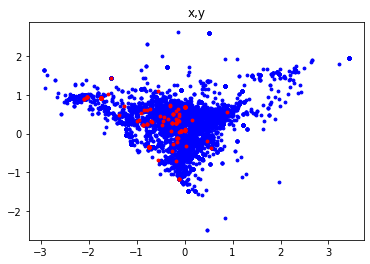

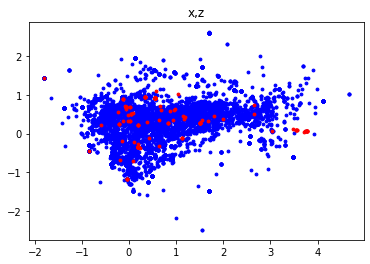

In [9]:
import matplotlib.pyplot as plt 

x_b = x2[y==0]
x_r = x2[y>0]

print(x_b.shape[0],"benign", x_r.shape[0],"mal")

plt.scatter(x_b[:,0], x_b[:,1], color='blue', s=8)
plt.scatter(x_r[:,0], x_r[:,1], color='red', s=8)
plt.title('x,y')
plt.show()

plt.scatter(x_b[:,2], x_b[:,1], color='blue', s=8)
plt.scatter(x_r[:,2], x_r[:,1], color='red', s=8)
plt.title('y,z')
plt.show()

In [10]:
g.x.size()

torch.Size([46726, 67])

: 